## Import Libraries

In [2]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


In [3]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import transformers
from transformers import pipeline

## Load data

In [5]:
data = pd.read_csv("book_reviews_sample.csv")
data.head()

,index,reviewText,rating
0,11494,Clean and funny. A bit busy with all the diffe...,3
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4
2,1463,Good thing that this is a free story. I read i...,1
3,10342,"Action, action, action! Equipment keeps gettin...",4
4,5256,this was hands down the worse book i have ever...,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       100 non-null    int64 
 1   reviewText  100 non-null    object
 2   rating      100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


## Data Cleaning

In [7]:
# lowercase
data['reviewText_clean'] = data['reviewText'].str.lower()

In [8]:
# remove punctuation
data['reviewText_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['reviewText_clean']), axis=1)

In [9]:
data.head()

,index,reviewText,rating,reviewText_clean
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...


## Rule-based sentiment with VADER

In [10]:
vader_sentiment = SentimentIntensityAnalyzer()

In [11]:
data['vader_sentiment_score'] = data['reviewText_clean'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

In [12]:
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767


In [13]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [14]:
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score,vader_sentiment_label
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684,positive
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325,positive
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740,positive
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652,positive
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767,negative


<Axes: xlabel='vader_sentiment_label'>

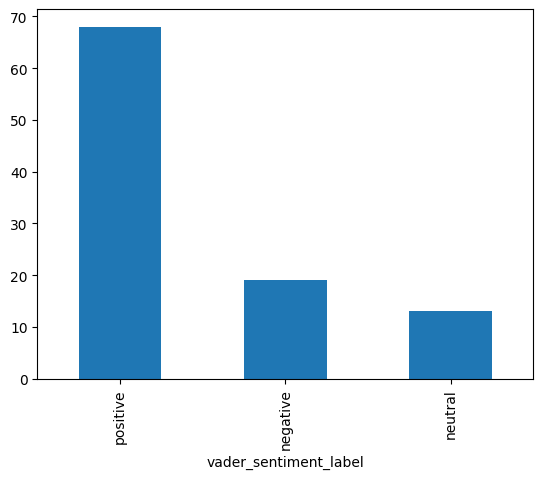

In [15]:
data['vader_sentiment_label'].value_counts().plot.bar()

## Pre-trained Transformer Model

In [16]:
transformer_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
transformer_labels = []

for review in data['reviewText_clean'].values:
    sentiment_list = transformer_pipeline(review)
    sentiment_label = [sent['label'] for sent in sentiment_list]
    transformer_labels.append(sentiment_label)

data['transformer_sentiment_label'] = transformer_labels

In [18]:
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score,vader_sentiment_label,transformer_sentiment_label
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684,positive,[POSITIVE]
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325,positive,[POSITIVE]
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740,positive,[NEGATIVE]
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652,positive,[NEGATIVE]
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767,negative,[NEGATIVE]


<Axes: xlabel='transformer_sentiment_label'>

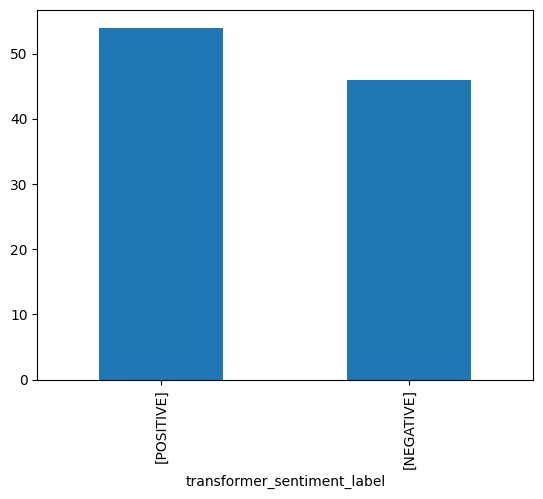

In [19]:
data['transformer_sentiment_label'].value_counts().plot.bar()